# Analyse Exploratoire : Prédiction du Churn Bancaire

---

## Contexte du projet

Le **churn** (attrition client) représente un enjeu majeur pour les institutions bancaires. Perdre un client implique non seulement une perte de revenus directs, mais également des coûts d'acquisition élevés pour le remplacer (estimés entre 5 à 25 fois plus chers que la fidélisation).

### Objectifs de cette analyse

1. Comprendre les caractéristiques des clients qui quittent la banque
2. Identifier les facteurs prédictifs du churn
3. Détecter les patterns cachés dans les comportements clients
4. Préparer les données pour la modélisation prédictive


## Chargement des bibliothèques

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, mannwhitneyu  #  pour les tests statistiques

# Configuration globale
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

# Configuration visuelle
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.1)

# Constantes graphiques
COULEUR_PRINCIPALE = '#2E86AB'
COULEUR_CHURN = '#E63946'
COULEUR_RESTE = '#06A77D'
PALETTE_CUSTOM = [COULEUR_RESTE, COULEUR_CHURN]

---
# Section 1 : Chargement et Aperçu Initial des Données

In [2]:
df = pd.read_csv('../data/raw/bank_churn.csv')

print(f"Dataset chargé: {df.shape[0]} lignes, {df.shape[1]} colonnes")
print("\nPremières lignes:")
df.head(10)

Dataset chargé: 10000 lignes, 13 colonnes

Premières lignes:


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,Num Of Products,Has Credit Card,Is Active Member,Estimated Salary,Churn
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


In [3]:
print("informations sur le dataset: ")
print(df.info())
print("="*70)
print(f"Valeurs manquantes : {df.isnull().sum().sum()}")
print(f"Doublons : {df.duplicated().sum()}")

informations sur le dataset: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerId        10000 non-null  int64  
 1   Surname           10000 non-null  object 
 2   CreditScore       10000 non-null  int64  
 3   Geography         10000 non-null  object 
 4   Gender            10000 non-null  object 
 5   Age               10000 non-null  int64  
 6   Tenure            10000 non-null  int64  
 7   Balance           10000 non-null  float64
 8   Num Of Products   10000 non-null  int64  
 9   Has Credit Card   10000 non-null  int64  
 10  Is Active Member  10000 non-null  int64  
 11  Estimated Salary  10000 non-null  float64
 12  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB
None
Valeurs manquantes : 0
Doublons : 0


### Dictionnaire des variables

| Variable | Type | Description |
|----------|------|-------------|
| **CustomerId** | Numérique | Identifiant unique du client |
| **Surname** | Catégoriel | Nom de famille |
| **CreditScore** | Numérique | Score de crédit (300-850) |
| **Geography** | Catégoriel | Pays (France, Allemagne, Espagne) |
| **Gender** | Catégoriel | Genre (Male/Female) |
| **Age** | Numérique | Âge du client |
| **Tenure** | Numérique | Ancienneté (années avec la banque) |
| **Balance** | Numérique | Solde du compte |
| **Num Of Products** | Numérique | Nombre de produits bancaires |
| **Has Credit Card** | Binaire | Possession d'une carte de crédit (0/1) |
| **Is Active Member** | Binaire | Membre actif ou non (0/1) |
| **Estimated Salary** | Numérique | Salaire estimé |
| **Churn** | Binaire | **Variable cible** : Client parti (1) ou resté (0) |

---
# Section 2 : Qualité des Données et Statistiques Descriptives

In [4]:
print("\n Statistiques Descriptives")
display(df.describe().T)

print("\nSTATISTIQUES DESCRIPTIVES (Variables numériques)")
print("="*70)

numeric_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'Num Of Products', 'Estimated Salary']
stats_df = df[numeric_vars].describe().T

# Ajout de statistiques supplémentaires
stats_df['skewness'] = df[numeric_vars].skew()  # Asymétrie
stats_df['kurtosis'] = df[numeric_vars].kurtosis() # Aplatissement

display(stats_df.round(2))


 Statistiques Descriptives


,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.0,1.57e+07,71936.19,1.56e+07,1.56e+07,1.57e+07,1.58e+07,1.58e+07
CreditScore,10000.0,6.51e+02,96.65,3.50e+02,5.84e+02,6.52e+02,7.18e+02,8.50e+02
Age,10000.0,3.89e+01,10.49,1.80e+01,3.20e+01,3.70e+01,4.40e+01,9.20e+01
Tenure,10000.0,5.01e+00,2.89,0.00e+00,3.00e+00,5.00e+00,7.00e+00,1.00e+01
Balance,10000.0,7.65e+04,62397.41,0.00e+00,0.00e+00,9.72e+04,1.28e+05,2.51e+05
Num Of Products,10000.0,1.53e+00,0.58,1.00e+00,1.00e+00,1.00e+00,2.00e+00,4.00e+00
Has Credit Card,10000.0,7.06e-01,0.46,0.00e+00,0.00e+00,1.00e+00,1.00e+00,1.00e+00
Is Active Member,10000.0,5.15e-01,0.50,0.00e+00,0.00e+00,1.00e+00,1.00e+00,1.00e+00
Estimated Salary,10000.0,1.00e+05,57510.49,1.16e+01,5.10e+04,1.00e+05,1.49e+05,2.00e+05
Churn,10000.0,2.04e-01,0.40,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00



STATISTIQUES DESCRIPTIVES (Variables numériques)


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
CreditScore,10000.0,650.53,96.65,350.00,584.00,652.00,718.00,850.00,-0.07,-0.43
Age,10000.0,38.92,10.49,18.00,32.00,37.00,44.00,92.00,1.01,1.40
Tenure,10000.0,5.01,2.89,0.00,3.00,5.00,7.00,10.00,0.01,-1.17
Balance,10000.0,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09,-0.14,-1.49
Num Of Products,10000.0,1.53,0.58,1.00,1.00,1.00,2.00,4.00,0.75,0.58
Estimated Salary,10000.0,100090.24,57510.49,11.58,51002.11,100193.92,149388.25,199992.48,0.00,-1.18



DISTRIBUTION DE LA VARIABLE CIBLE (CHURN)

Clients restés (0) : 7,963 (79.63%)
Clients partis (1)  : 2,037 (20.37%)

Ratio de déséquilibre : 3.91:1


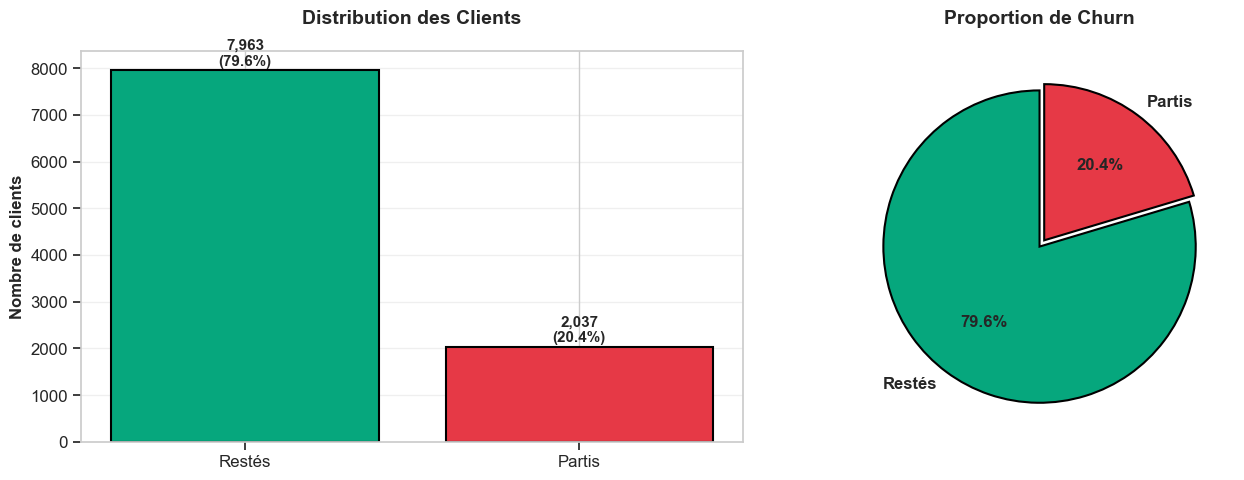

In [5]:
print("\nDISTRIBUTION DE LA VARIABLE CIBLE (CHURN)")
print("="*70)

churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print(f"\nClients restés (0) : {churn_counts[0]:,} ({churn_pct[0]:.2f}%)")
print(f"Clients partis (1)  : {churn_counts[1]:,} ({churn_pct[1]:.2f}%)")
print(f"\nRatio de déséquilibre : {churn_pct[0]/churn_pct[1]:.2f}:1")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Graphique en barres
ax1.bar(['Restés', 'Partis'], churn_counts, color=PALETTE_CUSTOM, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Nombre de clients', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Clients', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(churn_counts):
    ax1.text(i, v + 100, f'{v:,}\n({churn_pct.iloc[i]:.1f}%)', 
             ha='center', fontsize=11, fontweight='bold')

# Graphique circulaire
colors_pie = [PALETTE_CUSTOM[0], PALETTE_CUSTOM[1]]
explode = (0, 0.05)
ax2.pie(churn_counts, labels=['Restés', 'Partis'], autopct='%1.1f%%',
        startangle=90, colors=colors_pie, explode=explode,
        textprops={'fontsize': 12, 'fontweight': 'bold'},
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
ax2.set_title('Proportion de Churn', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

* Observation : Le dataset présente un déséquilibre de classe (environ 4:1).
* Cela devra être pris en compte lors de la modélisation (SMOTE, class_weight,)

---
# Section 3 : Analyse Univariée

L'analyse univariée permet de comprendre la distribution de chaque variable individuellement, avant d'étudier leurs relations avec le churn.

DISTRIBUTION DES VARIABLES CATÉGORIELLES

Geography :
  France          : 5,014 (50.14%)
  Germany         : 2,509 (25.09%)
  Spain           : 2,477 (24.77%)

Gender :
  Male            : 5,457 (54.57%)
  Female          : 4,543 (45.43%)


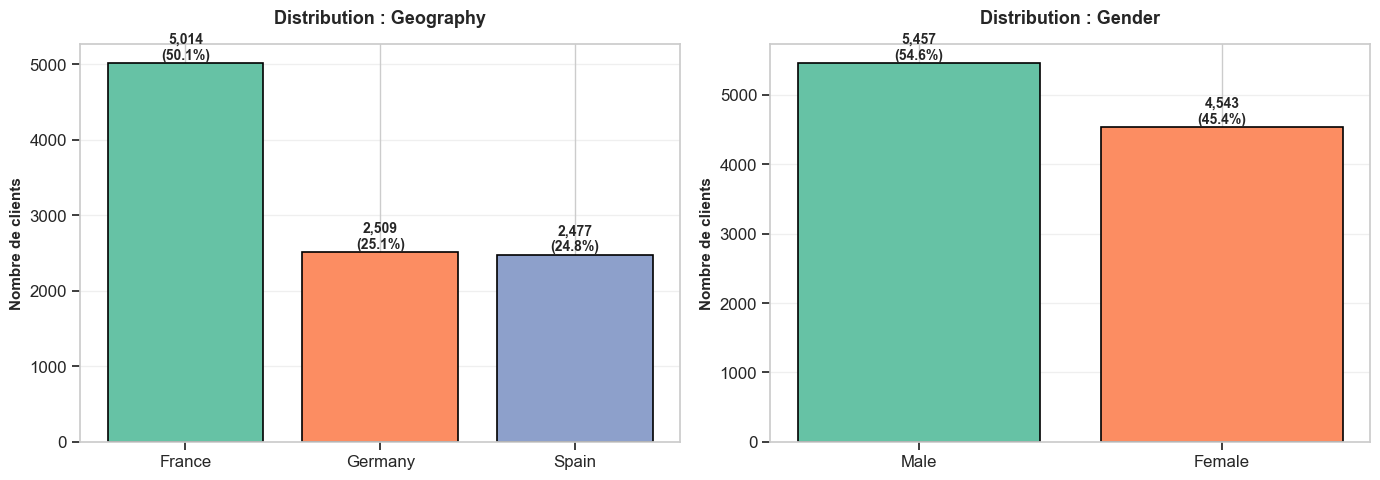

In [6]:
print("DISTRIBUTION DES VARIABLES CATÉGORIELLES")
print("="*70)

categorical_vars = ['Geography', 'Gender']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, var in enumerate(categorical_vars):
    counts = df[var].value_counts()
    percentages = df[var].value_counts(normalize=True) * 100
    
    # Création du graphique
    bars = axes[idx].bar(range(len(counts)), counts, 
                         color=sns.color_palette("Set2", len(counts)),
                         edgecolor='black', linewidth=1.2)
    
    axes[idx].set_xticks(range(len(counts)))
    axes[idx].set_xticklabels(counts.index, rotation=0)
    axes[idx].set_ylabel('Nombre de clients', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Distribution : {var}', fontsize=13, fontweight='bold', pad=15)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Annotations
    for i, (count, pct) in enumerate(zip(counts, percentages)):
        axes[idx].text(i, count + 50, f'{count:,}\n({pct:.1f}%)', 
                      ha='center', fontsize=10, fontweight='bold')
    
    print(f"\n{var} :")
    for cat, cnt, pct in zip(counts.index, counts, percentages):
        print(f"  {cat:15} : {cnt:5,} ({pct:5.2f}%)")

plt.tight_layout()
plt.show()


DISTRIBUTION DES VARIABLES NUMÉRIQUES


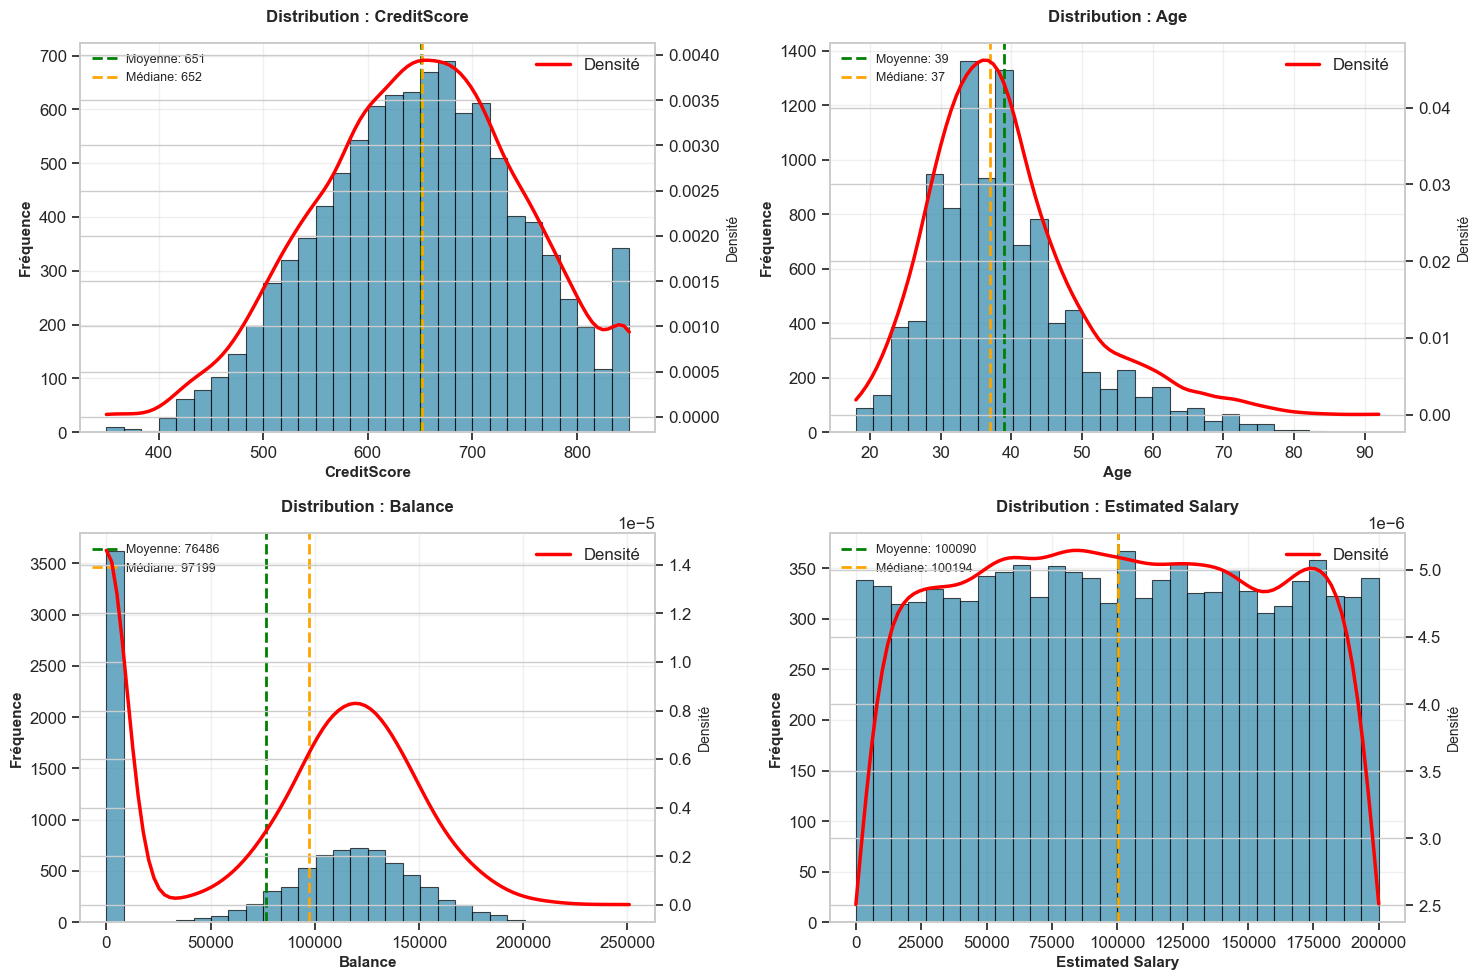


Asymétrie des distributions (Skewness) :
  CreditScore          :  -0.07  (symétrique)
  Age                  :   1.01  (asymétrie droite)
  Balance              :  -0.14  (symétrique)
  Estimated Salary     :   0.00  (symétrique)


In [7]:
print("\nDISTRIBUTION DES VARIABLES NUMÉRIQUES")
print("="*70)

continuous_vars = ['CreditScore', 'Age', 'Balance', 'Estimated Salary']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, var in enumerate(continuous_vars):
    # Histogramme avec KDE
    axes[idx].hist(df[var].dropna(), bins=30, color=COULEUR_PRINCIPALE, 
                   alpha=0.7, edgecolor='black', linewidth=0.8)
    
    # Ajout de la courbe KDE
    from scipy.stats import gaussian_kde
    data_clean = df[var].dropna()
    kde = gaussian_kde(data_clean)
    x_range = np.linspace(data_clean.min(), data_clean.max(), 100)
    ax2 = axes[idx].twinx()
    ax2.plot(x_range, kde(x_range), color='red', linewidth=2.5, label='Densité')
    ax2.set_ylabel('Densité', fontsize=10)
    ax2.legend(loc='upper right')
    
    # Statistiques
    mean_val = df[var].mean()
    median_val = df[var].median()
    axes[idx].axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Moyenne: {mean_val:.0f}')
    axes[idx].axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Médiane: {median_val:.0f}')
    
    axes[idx].set_xlabel(var, fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Fréquence', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Distribution : {var}', fontsize=12, fontweight='bold', pad=15)
    axes[idx].legend(loc='upper left', fontsize=9)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Identification des asymétries
print("\nAsymétrie des distributions (Skewness) :")
for var in continuous_vars:
    skew = df[var].skew()
    interpretation = "symétrique" if abs(skew) < 0.5 else ("asymétrie droite" if skew > 0 else "asymétrie gauche")
    print(f"  {var:20} : {skew:6.2f}  ({interpretation})")


DÉTECTION DES VALEURS ABERRANTES (Méthode IQR)


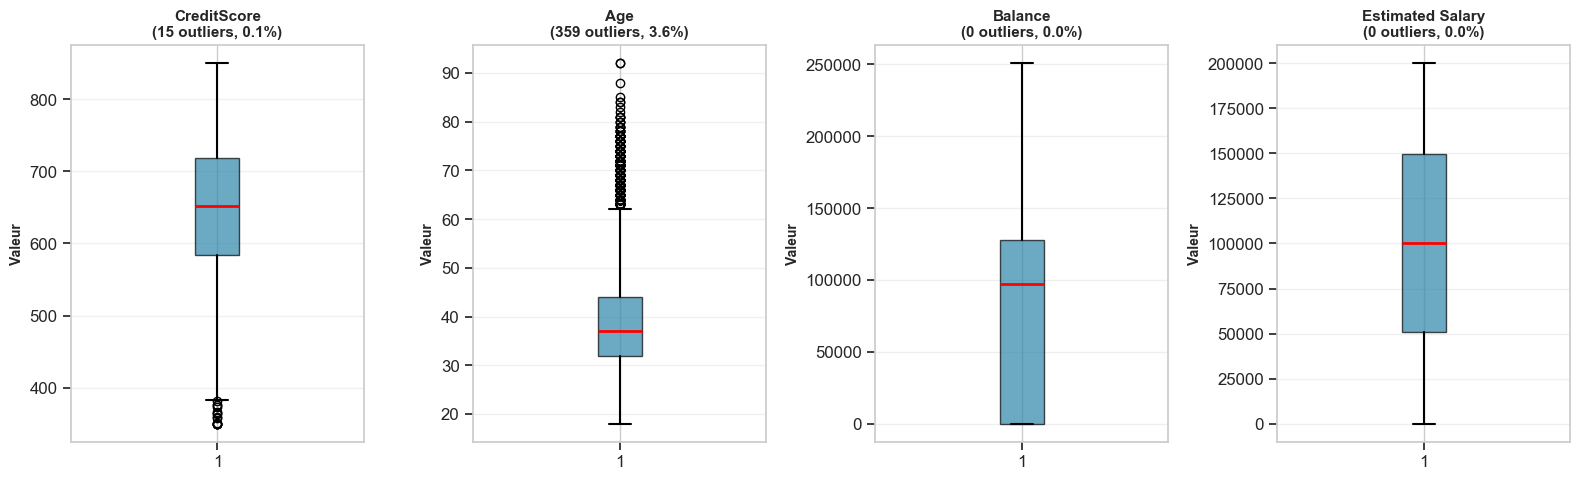


Résumé des outliers :


,Variable,Nb Outliers,Pourcentage (%)
0,CreditScore,15,0.15
1,Age,359,3.59
2,Balance,0,0.00
3,Estimated Salary,0,0.00


In [8]:
# Détection des valeurs aberrantes (outliers)
print("\nDÉTECTION DES VALEURS ABERRANTES (Méthode IQR)")
print("="*70)

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

outlier_summary = []

for idx, var in enumerate(continuous_vars):
    # Calcul IQR
    Q1 = df[var].quantile(0.25)
    Q3 = df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Comptage des outliers
    outliers = df[(df[var] < lower_bound) | (df[var] > upper_bound)]
    n_outliers = len(outliers)
    pct_outliers = (n_outliers / len(df)) * 100
    
    outlier_summary.append({
        'Variable': var,
        'Nb Outliers': n_outliers,
        'Pourcentage (%)': pct_outliers
    })
    
    # Boxplot
    bp = axes[idx].boxplot(df[var].dropna(), vert=True, patch_artist=True,
                           boxprops=dict(facecolor=COULEUR_PRINCIPALE, alpha=0.7),
                           medianprops=dict(color='red', linewidth=2),
                           whiskerprops=dict(linewidth=1.5),
                           capprops=dict(linewidth=1.5))
    
    axes[idx].set_ylabel('Valeur', fontsize=10, fontweight='bold')
    axes[idx].set_title(f'{var}\n({n_outliers} outliers, {pct_outliers:.1f}%)', 
                       fontsize=11, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Tableau récapitulatif
print("\nRésumé des outliers :")
display(pd.DataFrame(outlier_summary))

* Les outliers ne seront pas supprimés car ils peuvent contenir des informations importantes sur les comportements extrêmes liés au churn. 

---
# Section 4 : Analyse Bivariée (Relation avec le Churn)

Cette section explore la relation entre chaque variable et la variable cible (Churn). Des tests statistiques sont utilisés pour confirmer la significativité des observations visuelles.

ANALYSE DU CHURN PAR GÉOGRAPHIE

Statistiques par pays :


,Total,Churn,Taux (%)
Geography,,,
France,5014,810,16.2
Germany,2509,814,32.4
Spain,2477,413,16.7



Test du Chi-2 : χ² = 301.26, p-value = 0.0000
Relation statistiquement significative (p < 0.05)


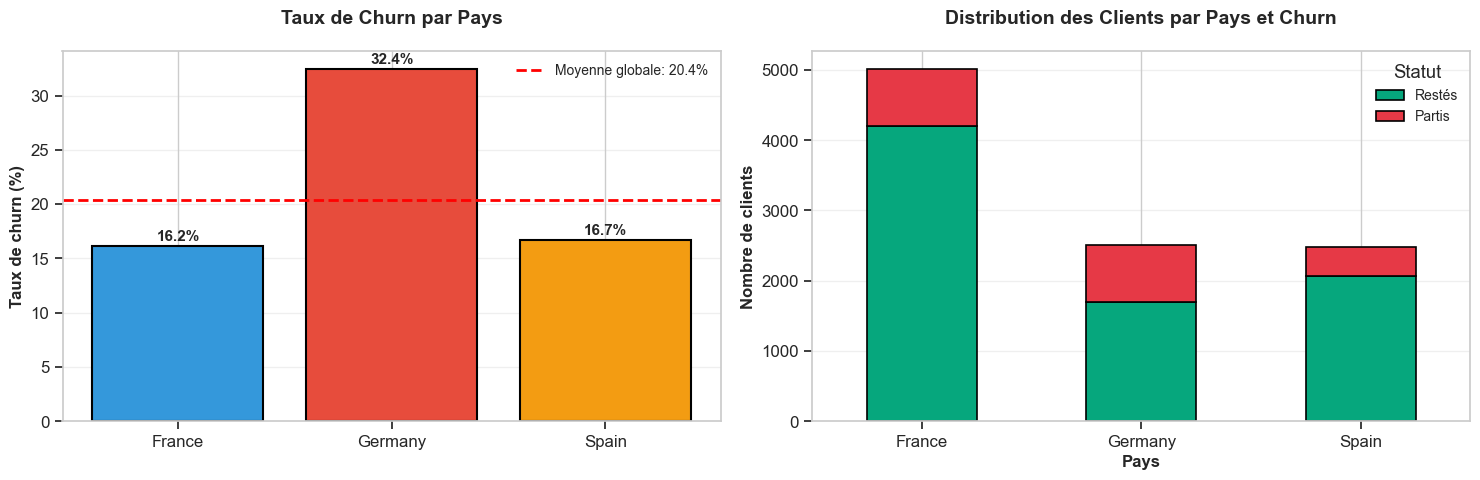

In [9]:
# Churn selon la géographie
print("ANALYSE DU CHURN PAR GÉOGRAPHIE")
print("="*70)

# Calcul des statistiques
geo_stats = df.groupby('Geography').agg({
    'Churn': ['count', 'sum', 'mean']
}).round(3)
geo_stats.columns = ['Total', 'Churn', 'Taux (%)']
geo_stats['Taux (%)'] *= 100

print("\nStatistiques par pays :")
display(geo_stats)

# Test du Chi-2
contingency = pd.crosstab(df['Geography'], df['Churn'])
chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f"\nTest du Chi-2 : χ² = {chi2:.2f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Relation statistiquement significative (p < 0.05)")
else:
    print("Pas de relation significative (p >= 0.05)")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Graphique 1: Taux de churn par pays
churn_by_geo = df.groupby('Geography')['Churn'].mean() * 100
bars = ax1.bar(churn_by_geo.index, churn_by_geo.values, 
               color=['#3498db', '#e74c3c', '#f39c12'],
               edgecolor='black', linewidth=1.5)
ax1.axhline(y=df['Churn'].mean()*100, color='red', linestyle='--', 
            linewidth=2, label=f'Moyenne globale: {df["Churn"].mean()*100:.1f}%')
ax1.set_ylabel('Taux de churn (%)', fontsize=12, fontweight='bold')
ax1.set_title('Taux de Churn par Pays', fontsize=14, fontweight='bold', pad=20)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(churn_by_geo.values):
    ax1.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Graphique 2: Distribution empilée
geo_pivot = df.groupby(['Geography', 'Churn']).size().unstack(fill_value=0)
geo_pivot.plot(kind='bar', stacked=True, ax=ax2, color=PALETTE_CUSTOM,
               edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Nombre de clients', fontsize=12, fontweight='bold')
ax2.set_title('Distribution des Clients par Pays et Churn', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Pays', fontsize=12, fontweight='bold')
ax2.legend(['Restés', 'Partis'], title='Statut', fontsize=10)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

* Observation : L'Allemagne présente un taux de churn significativement plus élevé.


ANALYSE DU CHURN PAR GENRE

Statistiques par genre :


,Total,Churn,Taux (%)
Gender,,,
Female,4543,1139,25.1
Male,5457,898,16.5



Test du Chi-2 : χ² = 112.92, p-value = 0.0000
Relation statistiquement significative (p < 0.05)


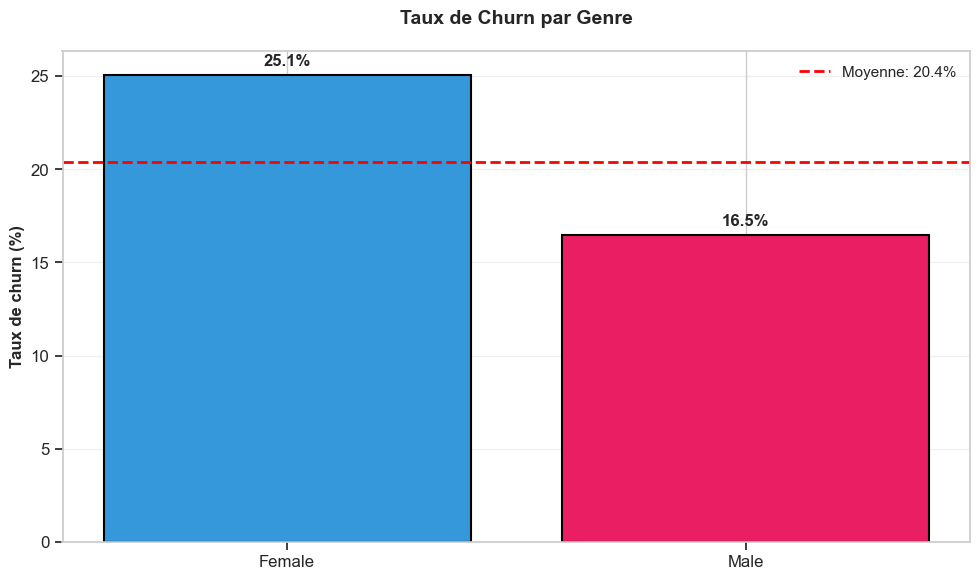

In [10]:
# Churn selon le genre
print("\nANALYSE DU CHURN PAR GENRE")
print("="*70)

# Statistiques
gender_stats = df.groupby('Gender').agg({
    'Churn': ['count', 'sum', 'mean']
}).round(3)
gender_stats.columns = ['Total', 'Churn', 'Taux (%)']
gender_stats['Taux (%)'] *= 100

print("\nStatistiques par genre :")
display(gender_stats)

# Test du Chi-2
contingency = pd.crosstab(df['Gender'], df['Churn'])
chi2, p_value, dof, expected = chi2_contingency(contingency)
print(f"\nTest du Chi-2 : χ² = {chi2:.2f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Relation statistiquement significative (p < 0.05)")

# Visualisation
fig, ax = plt.subplots(figsize=(10, 6))

churn_by_gender = df.groupby('Gender')['Churn'].mean() * 100
bars = ax.bar(churn_by_gender.index, churn_by_gender.values,
              color=['#3498db', '#e91e63'],
              edgecolor='black', linewidth=1.5)
ax.axhline(y=df['Churn'].mean()*100, color='red', linestyle='--',
           linewidth=2, label=f'Moyenne: {df["Churn"].mean()*100:.1f}%')
ax.set_ylabel('Taux de churn (%)', fontsize=12, fontweight='bold')
ax.set_title('Taux de Churn par Genre', fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

for i, v in enumerate(churn_by_gender.values):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

* Observation : Les femmes présentent un taux de churn plus élevé que les hommes.


ANALYSE DU CHURN PAR ÂGE

Statistiques par groupe d'âge :


,Total,Churn,Taux (%)
Age_Group,,,
<30,1968,148,7.5
30-40,4451,538,12.1
40-50,2320,788,34.0
50-60,797,448,56.2
>60,464,115,24.8



Test de Mann-Whitney : U = 11874649.50, p-value = 0.0000
Différence significative entre les distributions (p < 0.05)


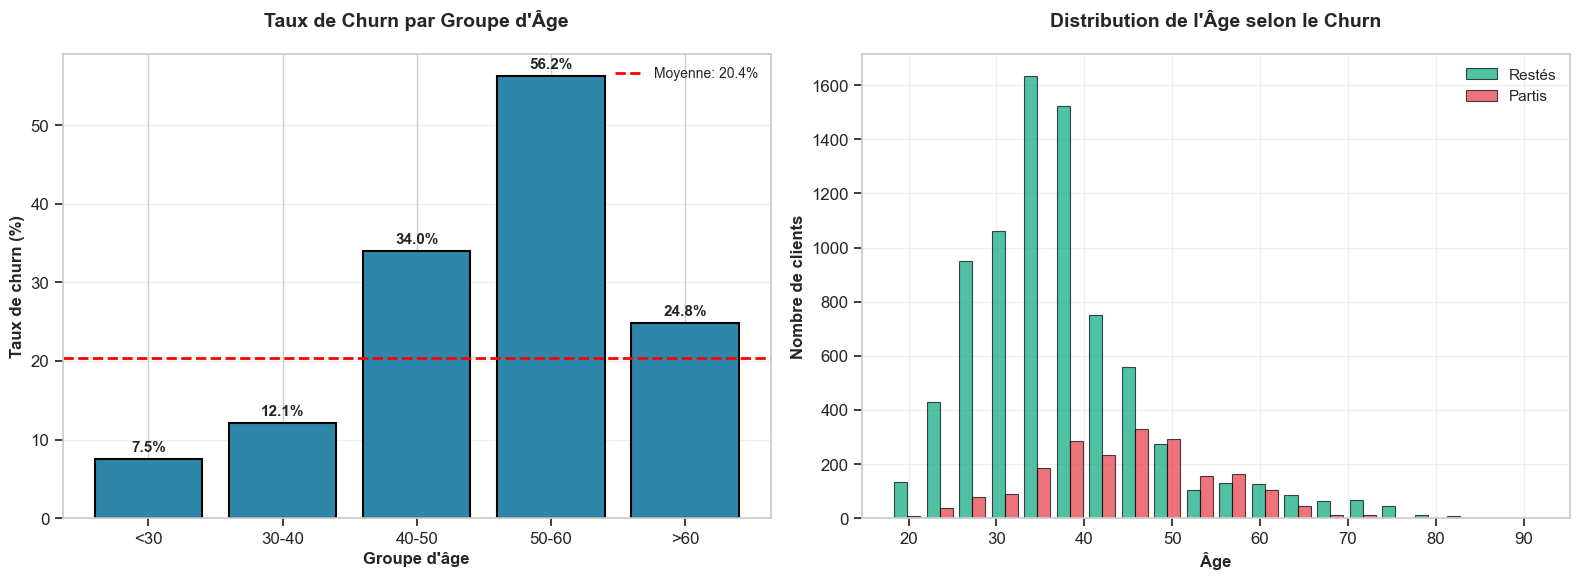

In [11]:
# Churn selon l'âge
print("\nANALYSE DU CHURN PAR ÂGE")
print("="*70)

# Création de groupes d'âge
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100],
                         labels=['<30', '30-40', '40-50', '50-60', '>60'])

# Statistiques
age_stats = df.groupby('Age_Group').agg({
    'Churn': ['count', 'sum', 'mean']
}).round(3)
age_stats.columns = ['Total', 'Churn', 'Taux (%)']
age_stats['Taux (%)'] *= 100

print("\nStatistiques par groupe d'âge :")
display(age_stats)

# Test de Mann-Whitney
churned = df[df['Churn'] == 1]['Age']
not_churned = df[df['Churn'] == 0]['Age']
statistic, p_value = mannwhitneyu(churned, not_churned)
print(f"\nTest de Mann-Whitney : U = {statistic:.2f}, p-value = {p_value:.4f}")
if p_value < 0.05:
    print("Différence significative entre les distributions (p < 0.05)")

# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Taux de churn par groupe d'âge
churn_by_age_group = df.groupby('Age_Group')['Churn'].mean() * 100
ax1.bar(range(len(churn_by_age_group)), churn_by_age_group.values,
        color=COULEUR_PRINCIPALE, edgecolor='black', linewidth=1.5)
ax1.axhline(y=df['Churn'].mean()*100, color='red', linestyle='--',
            linewidth=2, label=f'Moyenne: {df["Churn"].mean()*100:.1f}%')
ax1.set_xticks(range(len(churn_by_age_group)))
ax1.set_xticklabels(churn_by_age_group.index)
ax1.set_ylabel('Taux de churn (%)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Groupe d\'âge', fontsize=12, fontweight='bold')
ax1.set_title('Taux de Churn par Groupe d\'Âge', fontsize=14, fontweight='bold', pad=20)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(churn_by_age_group.values):
    ax1.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Graphique 2: Distribution de l'âge par statut de churn
ax2.hist([not_churned, churned], bins=20, label=['Restés', 'Partis'],
         color=PALETTE_CUSTOM, edgecolor='black', linewidth=0.8, alpha=0.7)
ax2.set_xlabel('Âge', fontsize=12, fontweight='bold')
ax2.set_ylabel('Nombre de clients', fontsize=12, fontweight='bold')
ax2.set_title('Distribution de l\'Âge selon le Churn', fontsize=14, fontweight='bold', pad=20)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

* Observation : Les clients de 40-60 ans ont un taux de churn significativement plus élevé.


ANALYSE DU CHURN PAR VARIABLES COMPORTEMENTALES


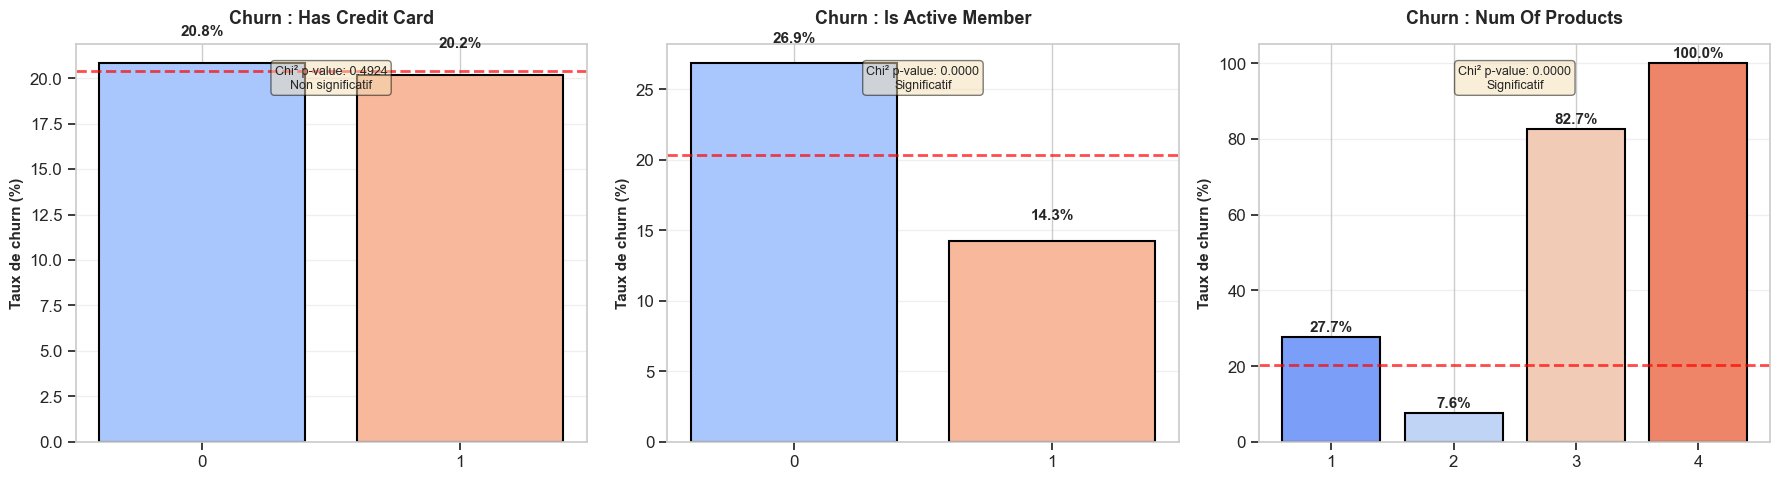


Focus sur le Nombre de Produits :


,Total clients,Churn,Taux (%)
Num Of Products,,,
1,5084,1409,27.7
2,4590,348,7.6
3,266,220,82.7
4,60,60,100.0


In [12]:
# Churn selon les variables binaires
print("\nANALYSE DU CHURN PAR VARIABLES COMPORTEMENTALES")
print("="*70)

binary_vars = ['Has Credit Card', 'Is Active Member', 'Num Of Products']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, var in enumerate(binary_vars):
    # Calcul des statistiques
    churn_rates = df.groupby(var)['Churn'].mean() * 100
    
    # Graphique
    bars = axes[idx].bar(range(len(churn_rates)), churn_rates.values,
                         color=sns.color_palette("coolwarm", len(churn_rates)),
                         edgecolor='black', linewidth=1.5)
    
    axes[idx].axhline(y=df['Churn'].mean()*100, color='red', linestyle='--',
                     linewidth=2, alpha=0.7)
    
    axes[idx].set_xticks(range(len(churn_rates)))
    axes[idx].set_xticklabels(churn_rates.index)
    axes[idx].set_ylabel('Taux de churn (%)', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Churn : {var}', fontsize=13, fontweight='bold', pad=15)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Annotations
    for i, v in enumerate(churn_rates.values):
        axes[idx].text(i, v + 1.5, f'{v:.1f}%', ha='center', 
                      fontsize=11, fontweight='bold')
    
    # Test statistique
    contingency = pd.crosstab(df[var], df['Churn'])
    chi2, p_value, _, _ = chi2_contingency(contingency)
    
    # Affichage du résultat du test
    significance = "Significatif" if p_value < 0.05 else "Non significatif"
    axes[idx].text(0.5, 0.95, f'Chi² p-value: {p_value:.4f}\n{significance}',
                  transform=axes[idx].transAxes, fontsize=9,
                  verticalalignment='top', horizontalalignment='center',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Analyse détaillée du nombre de produits
print("\nFocus sur le Nombre de Produits :")
products_analysis = df.groupby('Num Of Products').agg({
    'Churn': ['count', 'sum', 'mean']
}).round(3)
products_analysis.columns = ['Total clients', 'Churn', 'Taux (%)']
products_analysis['Taux (%)'] *= 100
display(products_analysis)

* Observations :
* Les clients INACTIFS ont un taux de churn environ 2x supérieur
* Les clients avec 3-4 produits ont un churn très élevé (à investiguer)
* La possession d'une carte de crédit a un impact limité


ANALYSE DU CHURN PAR VARIABLES FINANCIÈRES


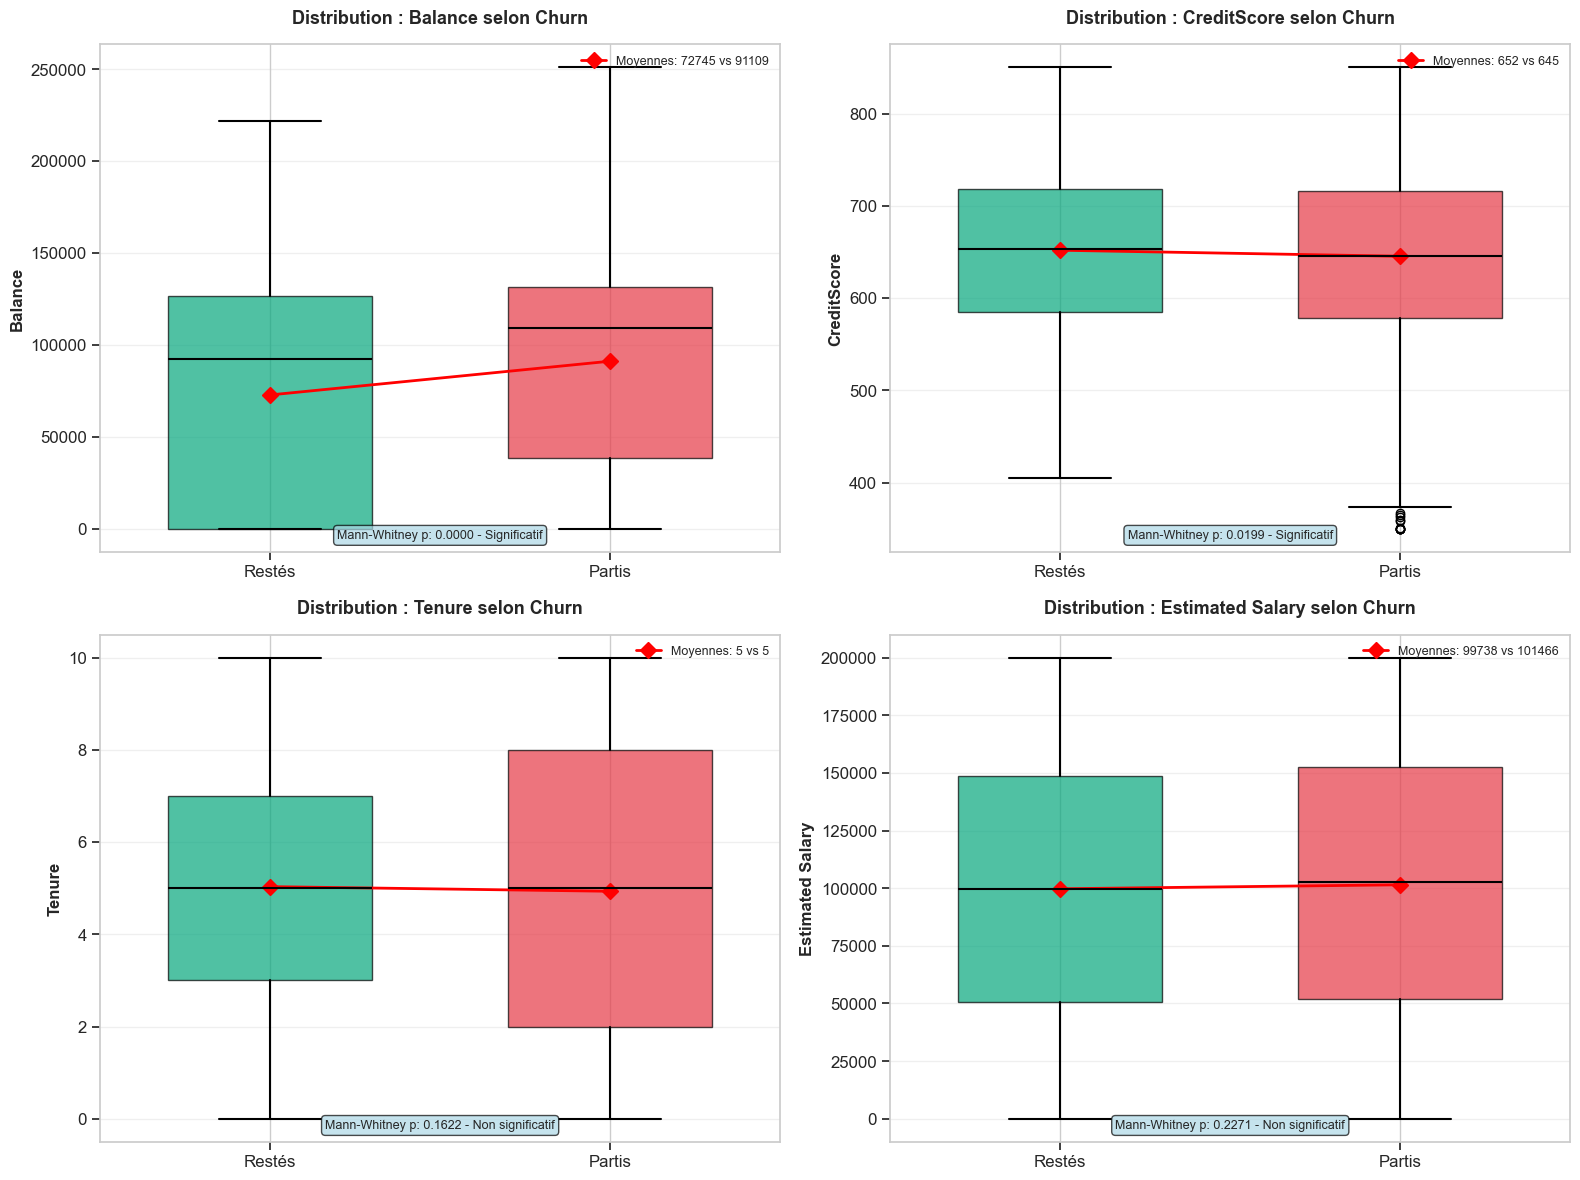

In [13]:
# Churn selon les variables continues
print("\nANALYSE DU CHURN PAR VARIABLES FINANCIÈRES")
print("="*70)

continuous_vars_analysis = ['Balance', 'CreditScore', 'Tenure', 'Estimated Salary']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, var in enumerate(continuous_vars_analysis):
    # Données par groupe
    churned = df[df['Churn'] == 1][var].dropna()
    not_churned = df[df['Churn'] == 0][var].dropna()
    
    # Boxplot comparatif
    bp = axes[idx].boxplot([not_churned, churned],
                           labels=['Restés', 'Partis'],
                           patch_artist=True,
                           widths=0.6)
    
    # Couleurs personnalisées
    for patch, color in zip(bp['boxes'], PALETTE_CUSTOM):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', linewidth=1.5)
    
    axes[idx].set_ylabel(var, fontsize=12, fontweight='bold')
    axes[idx].set_title(f'Distribution : {var} selon Churn', 
                       fontsize=13, fontweight='bold', pad=15)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Ajout des moyennes
    mean_not_churned = not_churned.mean()
    mean_churned = churned.mean()
    axes[idx].plot([1, 2], [mean_not_churned, mean_churned], 
                  'D-', color='red', markersize=8, linewidth=2, 
                  label=f'Moyennes: {mean_not_churned:.0f} vs {mean_churned:.0f}')
    axes[idx].legend(fontsize=9, loc='upper right')
    
    # Test de Mann-Whitney
    statistic, p_value = mannwhitneyu(churned, not_churned)
    significance = "Significatif" if p_value < 0.05 else "Non significatif"
    axes[idx].text(0.5, 0.02, f'Mann-Whitney p: {p_value:.4f} - {significance}',
                  transform=axes[idx].transAxes, fontsize=9,
                  verticalalignment='bottom', horizontalalignment='center',
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()
plt.show()

* Observations : 
* Balance : Soldes moyens plus élevés chez les clients partis
* CreditScore : Peu de différence entre les groupes
* Tenure : Les nouveaux clients (faible ancienneté) churent plus
* Salary : Impact limité sur le churn

---
# Section 5 : Analyse Multivariée

MATRICE DE CORRÉLATION DES VARIABLES NUMÉRIQUES


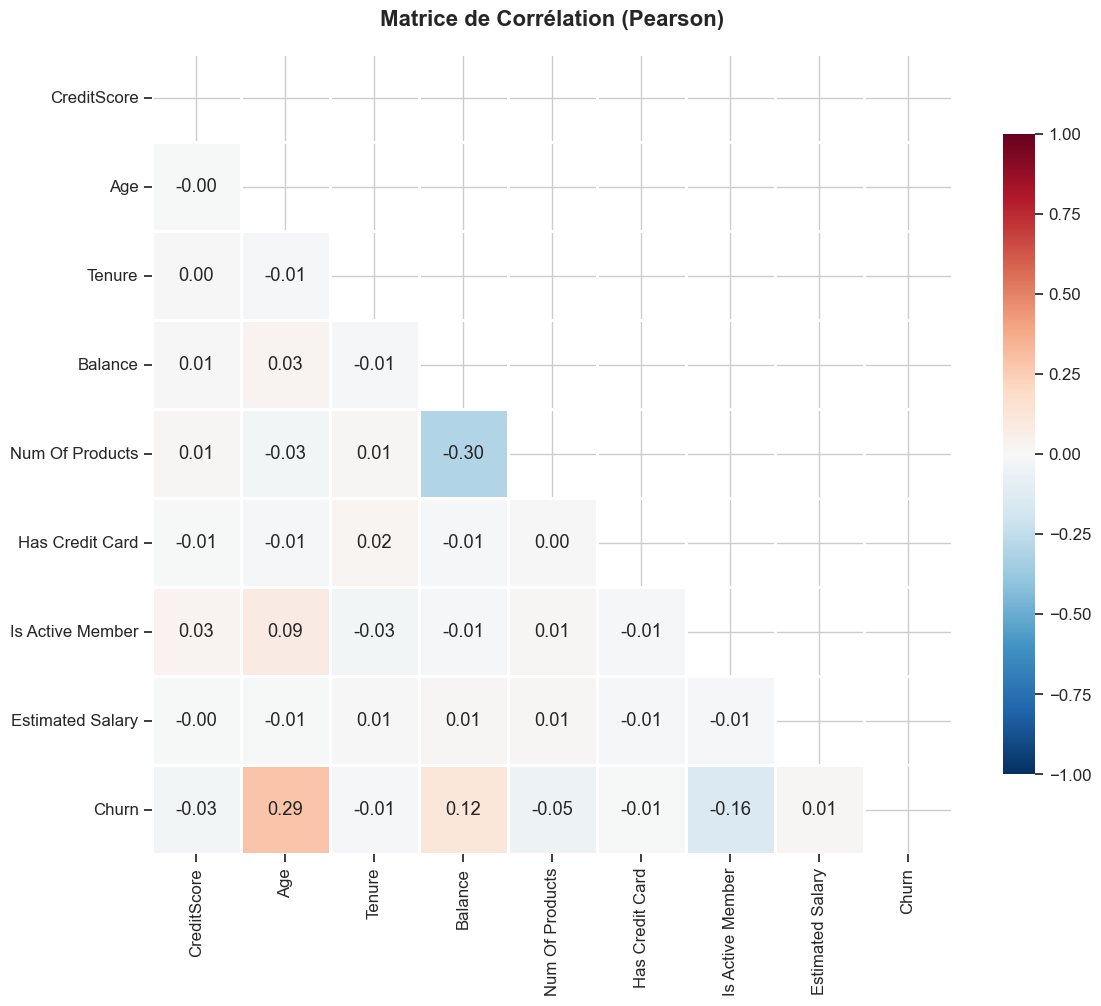


Top corrélations avec le Churn :
Age                 0.29
Is Active Member    0.16
Balance             0.12
Num Of Products     0.05
CreditScore         0.03
Name: Churn, dtype: float64


In [14]:
# Matrice de corrélation
print("MATRICE DE CORRÉLATION DES VARIABLES NUMÉRIQUES")
print("="*70)

# Sélection des variables numériques
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'Num Of Products',
                'Has Credit Card', 'Is Active Member', 'Estimated Salary', 'Churn']

# Calcul de la matrice de corrélation
corr_matrix = df[numeric_cols].corr()

# Visualisation avec heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation (Pearson)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Top corrélations avec Churn
print("\nTop corrélations avec le Churn :")
churn_corr = corr_matrix['Churn'].abs().sort_values(ascending=False)
print(churn_corr.drop('Churn').head(5))

* Observations :
* Age et Is Active Member sont les plus corrélés au churn
* Peu de multicolinéarité entre les variables 


ANALYSE DES INTERACTIONS : GÉOGRAPHIE × GENRE

Taux de churn (%) par Pays et Genre :


Gender,Female,Male
Geography,,
France,20.34,12.71
Germany,37.55,27.81
Spain,21.21,13.11


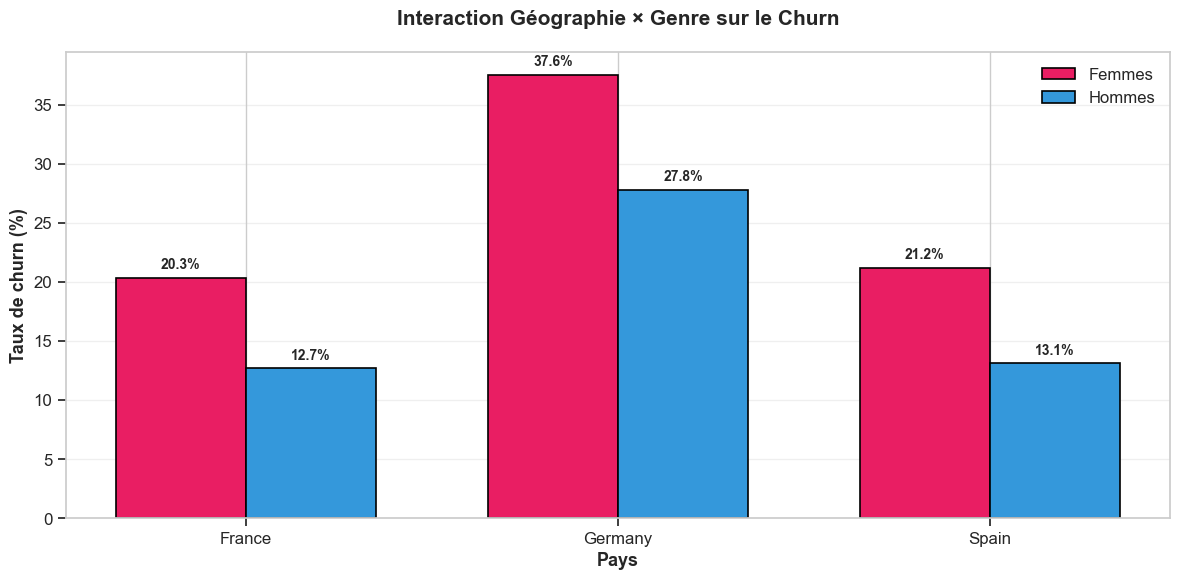

In [15]:
# Analyse d'interactions : Géographie × Genre
print("\nANALYSE DES INTERACTIONS : GÉOGRAPHIE × GENRE")
print("="*70)

# Pivot table
interaction_pivot = df.pivot_table(values='Churn', 
                                   index='Geography', 
                                   columns='Gender', 
                                   aggfunc='mean') * 100

print("\nTaux de churn (%) par Pays et Genre :")
display(interaction_pivot.round(2))

# Visualisation
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(interaction_pivot.index))
width = 0.35

bars1 = ax.bar(x - width/2, interaction_pivot['Female'], width, 
               label='Femmes', color='#e91e63', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, interaction_pivot['Male'], width,
               label='Hommes', color='#3498db', edgecolor='black', linewidth=1.2)

ax.set_xlabel('Pays', fontsize=13, fontweight='bold')
ax.set_ylabel('Taux de churn (%)', fontsize=13, fontweight='bold')
ax.set_title('Interaction Géographie × Genre sur le Churn', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(interaction_pivot.index)
ax.legend(fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Annotations
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

* Observation : Les femmes allemandes ont le taux de churn le plus élevé.


ANALYSE DES INTERACTIONS : ÂGE × ACTIVITÉ

Taux de churn (%) par Groupe d'Âge et Activité :


,Inactif,Actif
Age_Group,,
<30,10.08,5.07
30-40,14.94,9.21
40-50,41.60,25.41
50-60,85.71,34.71
>60,82.02,11.20


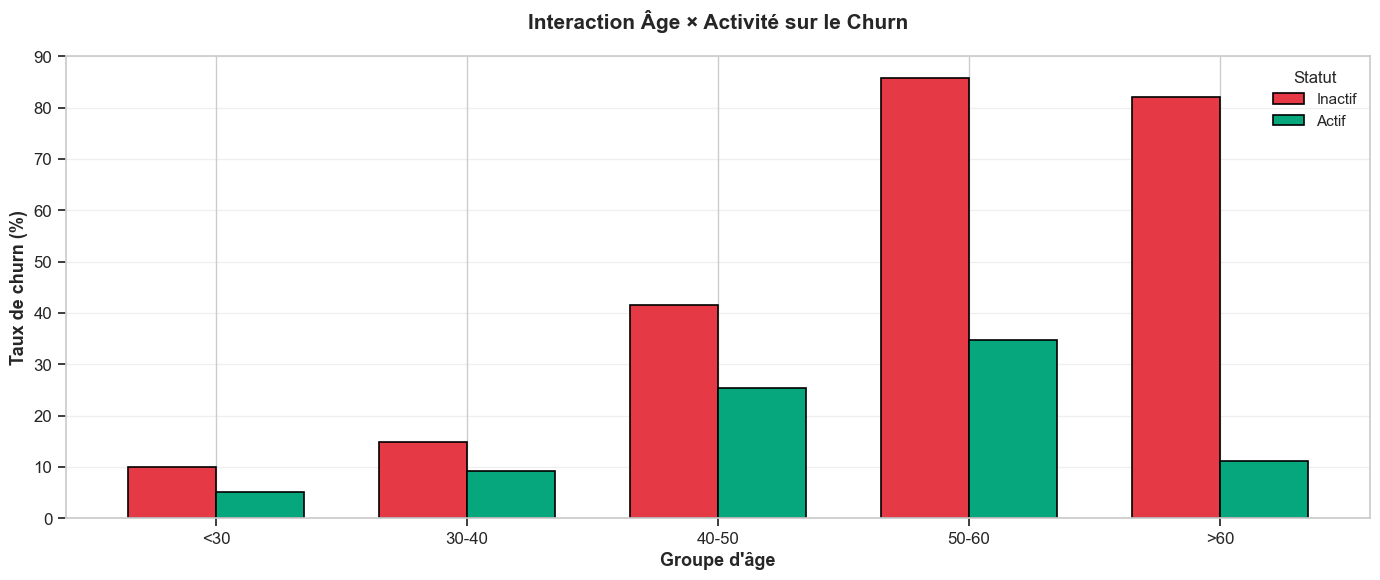

In [16]:
# Interaction : Âge × Activité
print("\nANALYSE DES INTERACTIONS : ÂGE × ACTIVITÉ")
print("="*70)

# Préparation des données
age_activity_pivot = df.pivot_table(values='Churn',
                                    index='Age_Group',
                                    columns='Is Active Member',
                                    aggfunc='mean') * 100
age_activity_pivot.columns = ['Inactif', 'Actif']

print("\nTaux de churn (%) par Groupe d'Âge et Activité :")
display(age_activity_pivot.round(2))

# Visualisation
fig, ax = plt.subplots(figsize=(14, 6))

age_activity_pivot.plot(kind='bar', ax=ax, color=[COULEUR_CHURN, COULEUR_RESTE],
                        edgecolor='black', linewidth=1.2, width=0.7)

ax.set_xlabel('Groupe d\'âge', fontsize=13, fontweight='bold')
ax.set_ylabel('Taux de churn (%)', fontsize=13, fontweight='bold')
ax.set_title('Interaction Âge × Activité sur le Churn',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(title='Statut', fontsize=11, title_fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

* Observation : L'inactivité amplifie l'effet de l'âge sur le churn. 

---
# Section 6 : Synthèse 

In [17]:
summary_data = [
    ['Âge', 'Numérique', 'Élevé', 'Oui', 'Clients 40-60 ans plus à risque'],
    ['Géographie', 'Catégoriel', 'Très élevé', 'Oui', 'Allemagne : taux 2x supérieur'],
    ['Genre', 'Catégoriel', 'Élevé', 'Oui', 'Femmes : +9 points vs hommes'],
    ['Is Active', 'Binaire', 'Très élevé', 'Oui', 'Inactifs : churn ~2x supérieur'],
    ['Nb Produits', 'Numérique', 'Élevé', 'Oui', '3-4 produits : anomalie (100%)'],
    ['Balance', 'Numérique', 'Modéré', 'Oui', 'Soldes élevés → plus de churn'],
    ['Tenure', 'Numérique', 'Modéré', 'Oui', 'Nouveaux clients plus volatils'],
    ['CreditScore', 'Numérique', 'Faible', 'Non', 'Pas de différence significative'],
    ['Salary', 'Numérique', 'Faible', 'Non', 'Impact négligeable'],
    ['Has CC', 'Binaire', 'Très faible', 'Non', 'Aucun effet sur le churn'],
]

summary_df = pd.DataFrame(summary_data, 
                         columns=['Variable', 'Type', 'Impact', 'Significatif', 'Observation'])
display(summary_df)

,Variable,Type,Impact,Significatif,Observation
0,Âge,Numérique,Élevé,Oui,Clients 40-60 ans plus à risque
1,Géographie,Catégoriel,Très élevé,Oui,Allemagne : taux 2x supérieur
2,Genre,Catégoriel,Élevé,Oui,Femmes : +9 points vs hommes
3,Is Active,Binaire,Très élevé,Oui,Inactifs : churn ~2x supérieur
4,Nb Produits,Numérique,Élevé,Oui,3-4 produits : anomalie (100%)
5,Balance,Numérique,Modéré,Oui,Soldes élevés → plus de churn
6,Tenure,Numérique,Modéré,Oui,Nouveaux clients plus volatils
7,CreditScore,Numérique,Faible,Non,Pas de différence significative
8,Salary,Numérique,Faible,Non,Impact négligeable
9,Has CC,Binaire,Très faible,Non,Aucun effet sur le churn


# FIN DE L'ANALYSE EXPLORATOIRE 